In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import linearmodels

import seaborn as sns


# Introduction

In this project, I'm further developing my ECON 490 thesis paper, in which I found that centrist Democratic candidates to the House of Representatives were much more likely, and very liberal candidates were much less likely, to win their elections than the baseline group. 

What I'm interested in now is not statistical significance, but seeing if I can generalize the models, test for overfitting, and get a good balance of variables to include to balance the various prediction metrics.

It will be structured in the following manner:


1. Introducing the dataset
    - Discussion of variables
    
2. Creating the initial models
    - Linear probability model
    - Logit probability model
    - The "Unfrazzled no-hassle lasso progressive regression digression"
    - Testing accuracy
    - Testing precision
    - Testing recall
 
3. Improving the models
    - Region
    - Race
    - Candidate
    - Urbanization
    - Testing accuracy
    - Picking the best model

4. Counterfactual Predictions
    - What if all Democrats ran as centrists?
    - What if all Democrats ran as liberals?

# Phase 1: Introducing the Dataset

The final dataset created for my paper was `a_m_d_11`, standing for "aligned model dataset version 11." It included data from multiple sources, ranging from an MIT Election Data + Science Lab dataset (acting as the core), to economic and demographic data from the US Census, to political leaning data from the Cook Partisan Voter Index, urbanization data, and others. It is printed below, with a list of columns.  

In [2]:
a_m_d_11 = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRy5Ir4TrmGh77L131Xhkb22GIVWVF-4PF1eNjPOcOOpgtKyfyDcp4P2d8X4olqfifyJqo4SwTqSdH1/pub?gid=422096178&single=true&output=csv")

a_m_d_11.head(3)

,states,po,dist,cand,cand_votes,tot_votes,leaning,median_income,mean_income,unemployment_1,...,DICREX,RICDIN,RICDEX,DEXRIN,DINREX,DEXREX,DINRIN,median_income_std,two_party_vote,two_party_vote_share
0,ALABAMA,AL,1,ROBERT KENNEDY JR.,89226,242617,15,47952,66085,6.4,...,0,1,0,0,0,0,0,-0.897518,242454,0.368012
1,ALABAMA,AL,2,TABITHA ISNER,86931,226230,16,46817,63939,7.0,...,0,1,0,0,0,0,0,-0.963925,225810,0.384974
2,ALABAMA,AL,3,MALLORY HAGAN,83996,231915,16,46576,62954,6.9,...,0,1,0,0,0,0,0,-0.978026,231766,0.362417


In [3]:
win = a_m_d_11["win"]

In [4]:
a_m_d_11.columns

Index(['states', 'po', 'dist', 'cand', 'cand_votes', 'tot_votes', 'leaning',
       'median_income', 'mean_income', 'unemployment_1', 'unemployment_2',
       'white_pct', 'black_pct', 'native_pct', 'asian_pct', 'hispanic_pct',
       'blue_dog', 'justice_dem', 'dem_vote_pct', 'win', 'south', 'north_east',
       'mid_west', 'west', 'Incumbent', 'Open_Seat', 'urb_cluster',
       'Very low density', 'Low density', 'Medium density\t', 'High density',
       'pure_rural', 'rural_suburban_mix', 'sparse_suburban', 'dense_suburban',
       'urban_suburban_mix', 'pure_urban', 'high_ed_pct', 'state_dist', 'stcd',
       'inc', 'pwin', 'fr', 'po1', 'po2', 'redist', 'dexp', 'rexp',
       'total_spending', 'dem_spending_share', 'abnormal', 'DICRIN', 'DICREX',
       'RICDIN', 'RICDEX', 'DEXRIN', 'DINREX', 'DEXREX', 'DINRIN',
       'median_income_std', 'two_party_vote', 'two_party_vote_share'],
      dtype='object')

However, much of the dataset is vestigial and not used in the actual model. Some features and variables are worth explaining:

- The data collection level is at the district and candidate level. Most variables describe the congressional district, but some such as `Incumbent` and the set of onces like `DICRIN`, `DICREX`, etc, describe whether the Democrat in question is an incumbent representative, and the political experience level of them and their Republican opponent. 

- `blue_dog` and `justice_dem` are my indicators of political ideology. This was the main point of interest for my paper - did candidates' political ideology being extreme hurt or help them in the general election? `blue_dog` equalled 1 if a candidate was a member of the Blue Dog Coalition (a group of centrist Democrats) or 0 if they didn't, while `justice_dem` equalled 1 if they were a member of the Justice Democrats (a very liberal political organization) and 0 if not. None were members of both; those who were members of neither were assumed to lie in between. 

Some evidence of this lies below in a plot created for my paper: 

Party and Caucus on DW-NOMINATE.png

![Party and Caucus](img/PartyandCaucusonDW-NOMINATE.png)

The main separation between the Democratic and Republican parties is the horizontal axis, showing how liberal or conservative (ie. left or right wing) candidates are on issues of economic redistribution. As can be seen, Blue Dogs are the right-most Democrats, while Justice Democrat are among the left-most. 

Four Justice Democrats are actually assigned moderate positions, but this is due to them voting against the Democratic Party, from the left but with Republicans, making them get assigned moderate spaces. [The people who created DW-NOMINATE, the scaling system used here, consider it a limitation with the model.](https://voteview.com/articles/ocasio_cortez)

- `leaning` is taken from the Cook Partisan Voting Index, which takes each district's average vote between the Democratic and Republican presidential candidates over the past two elections and averages it out, to give approximate partisan leaning. It controls for how liberal or conservative a district is on average. Positive values indicate a leaning towards Republicans, negative values indicate towards Democrats. 

- `median_income_std` is household median income by district, standardized. 

- `incumbent` equals 1 if the Democrat is an incumbent representative and 0 if not. Later, I will use the `DICREX`, `DICRIN` etc. variables instead, which control for every combination of Democrat or Republican incumbent, and the experience level of either or both challengers (if an open seat). 

- I will also introduce variables covering `white_pct`, `black_pct`, and `hispanic_pct`, which indicate the racial breakdown of a district

- `west`, `south`, and `mid_west` indicate the federal region of a district. `north_east` is omitted to prevent perfect multicollinearity.

- Lastly, the `density` variables indicate how much of a district is composed of different levels of den

# Phase 2: Creating the Initial Models

In this project, I'm further developing my ECON 490 thesis paper, in which I found that centrist Democratic candidates to the House of Representatives were much more likely, and very liberal candidates were much less likely, to win their elections than the baseline group. 

What I'm interested in now is not statistical significance, but seeing if I can generalize the models, test for overfitting, and get a good balance of variables to include to balance the various prediction metrics.

## Creating Train/Test subsets of data, testing for overfitting

In [5]:
# Making X with urban rates values
X = pd.DataFrame({"blue_dog": a_m_d_11["blue_dog"],
                  "justice_dem": a_m_d_11["justice_dem"],
                  "leaning": a_m_d_11["leaning"],
                  "median_income_std": a_m_d_11["median_income_std"],
                 "incumbent": a_m_d_11["Incumbent"]
})

X = sm.add_constant(X)

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, win, test_size=0.50)

I will be running a linear probability model (an LPM, using OLS), a logistic probability model (logit), and a linear probability model using Lasso regression.

Note: The division between training and testing datasets is random every time. Your results may vary slightly from what is printed in the cells, though I have made an effort to insert the variable where possible. 

In [7]:
lpm_train = linear_model.LinearRegression()
lpm_train.fit(X_train, Y_train)
lpm_coefs_1 = pd.Series(dict(zip(list(X_train), lpm_train.coef_)))
lpm_coefs_1

const                0.000000
blue_dog             0.284747
justice_dem         -0.179746
leaning             -0.017555
median_income_std    0.085229
incumbent            0.297261
dtype: float64

In [8]:
logit_train = linear_model.LogisticRegression(solver="lbfgs")
logit_train.fit(X_train, Y_train)
logit_coefs_1 = pd.Series(dict(zip(list(X_train), logit_train.coef_.round(3))))


def ltc_returner(x):
    for number in x:
        return number


logit_coef = ltc_returner(logit_train.coef_)
logit_coef

array([ 1.77021401e-05,  1.23859734e+00, -3.08421434e-01, -4.41878976e-01,
        7.28653367e-01,  9.68214737e-01])

## The Unfrazzled, No-Hassle, Lasso Progressive Regression Digression

In the interest of making one very simple model to compare the more elaborate specifications against, I've run a linear probability model using Lasso regression, which shrinks effect sizes and in practice sets many coefficients equal to zero. I run it below as `lasso_model_1`.

In [9]:
lasso_model_1 = linear_model.Lasso()
lasso_model_1.fit(X_train, Y_train)

lasso_coefs_1 = pd.Series(dict(zip(list(X_train), lasso_model_1.coef_)))
lasso_coefs_1

const                0.000000
blue_dog             0.000000
justice_dem         -0.000000
leaning             -0.020769
median_income_std    0.000000
incumbent            0.000000
dtype: float64

## Comparing Results

In [10]:
coefs = ["const", "blue_dog", "justice_dem", "leaning", "median_income_std", "incumbent"]

coef_results = pd.DataFrame({#"coefs": coefs,
                             "lpm": lpm_coefs_1,
                            "logit": logit_coef,
                             #"logit": [-1.0000e-04,  1.7362e+00, -3.2600e-01, -4.8070e-01,  6.8980e-01,  8.0640e-01],
                             "lasso": lasso_coefs_1})
coef_results

,lpm,logit,lasso
const,0.000000,0.000018,0.000000
blue_dog,0.284747,1.238597,0.000000
justice_dem,-0.179746,-0.308421,-0.000000
leaning,-0.017555,-0.441879,-0.020769
median_income_std,0.085229,0.728653,0.000000
incumbent,0.297261,0.968215,0.000000


# Results thus far?

1. LPM and Logit models do show coefficient results on all but `const`
2. BUT: Lasso shows only `leaning` as having any coefficient

### How do their accuracies look?

In [11]:
lpm_train_accuracy = lpm_train.score(X_train, Y_train)
lpm_test_accuracy = lpm_train.score(X_test, Y_test)

print(f"LPM training dataset accuracy is: {lpm_train_accuracy}")
print(f"LPM testing dataset accuracy is: {lpm_test_accuracy}")

LPM training dataset accuracy is: 0.7120267695136987
LPM testing dataset accuracy is: 0.6805910921563088


In [12]:
logit_train_accuracy = logit_train.score(X_train, Y_train)
logit_test_accuracy = logit_train.score(X_test, Y_test)

print(f"Logit training dataset accuracy is: {logit_train_accuracy}")
print(f"Logit testing dataset accuracy is: {logit_test_accuracy}")

Logit training dataset accuracy is: 0.9489795918367347
Logit testing dataset accuracy is: 0.9693877551020408


In [13]:
lasso_train_accuracy = lasso_model_1.score(X_train, Y_train)
lasso_test_acuracy = lasso_model_1.score(X_test, Y_test)


print(f"Lasso training dataset accuracy is: {lasso_train_accuracy}")
print(f"Lasso testing dataset accuracy is: {lasso_test_acuracy}")

Lasso training dataset accuracy is: 0.6069187590068059
Lasso testing dataset accuracy is: 0.5832168022216864


In [14]:
accuracy_df = pd.DataFrame({"Type": ["Training", "Testing"],
                            "LPM": [0.667, 0.725],
                           "Logit": [0.944, 0.969],
                           "Lasso": [0.555, 0.636]})
accuracy_df = accuracy_df.set_index("Type")
accuracy_df

,LPM,Logit,Lasso
Type,,,
Training,0.667,0.944,0.555
Testing,0.725,0.969,0.636


## Question: What is the accuracy of just guessing the most likely outcome for both datasets?

Because this is a binary dependent variable, it's worth asking what your baseline accuracy is if you simply guess the more common outcome variable every single time.

In [15]:
training_mean = Y_train.mean()
testing_mean = Y_test.mean()

print(f"Average value in the training dataset is: {training_mean}")
print(f"Average value in the testing dataset is: {testing_mean}")

Average value in the training dataset is: 0.5051020408163265
Average value in the testing dataset is: 0.5051020408163265


In [16]:
# Set up so that if modal_training_value >= 0.5, go with it, if not, go with 1 - modal_training_value
# likewise for modal_testing_value

modal_training_value = Y_train.mean()
modal_testing_value = Y_test.mean()


if training_mean < 0.5:
    modal_training_value = 1 - modal_training_value
    
if modal_testing_value < 0.5:
    modal_testing_value = 1 - modal_testing_value

For example, if 1 makes up 49.5% of the training results, guessing 0 every time will give you an accuracy of (1 - 0.495) = 0.505. Because we want to improve on just guessing the most common result every time, we need to get at least this accuracy value for a model to be any use. 

I'll plot the "guess the same value every time" accuracy levels and those of the models, and see what we get.

In [17]:
Types = ["LPM Train", "LPM Test", 
         "Logit Train", "Logit Test",
         "Lasso Train", "Lasso Test"]

Accuracy = [lpm_train_accuracy, lpm_test_accuracy, logit_train_accuracy, logit_test_accuracy, lasso_train_accuracy, lasso_test_acuracy]

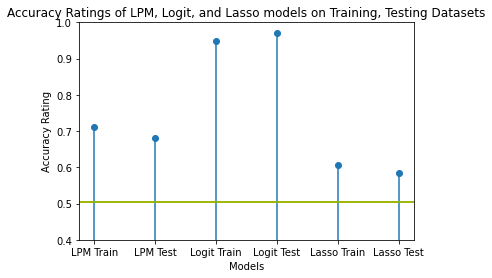

In [18]:

plt.stem(Accuracy)
plt.xticks(ticks = range(len(Types)), 
           labels = ["LPM Train", "LPM Test", "Logit Train", "Logit Test", "Lasso Train", "Lasso Test"], 
          )
plt.ylabel("Accuracy Rating")
plt.xlabel("Models")
plt.title("Accuracy Ratings of LPM, Logit, and Lasso models on Training, Testing Datasets")
plt.ylim([0.4, 1])

# Green Line is accuracy of guessing most common result (0) in Training dataset
plt.axhline(y=modal_training_value, color='g', linestyle='-')

# Yellow line is accuracy of guessing most common result (1) in Testing dataset
plt.axhline(y=modal_testing_value, color='y', linestyle='-')


#### Green Line is accuracy of guessing most common result in the Training dataset
#### Yellow line is accuracy of guessing most common result in the Testing dataset


### A note on false positives versus false negatives

Due to the nature of this experiment, we're wanting to predict if candidates are elected or not. A bit more than half were: `win.mean()` equals ~0.505. The breakdowns for the testing and training datasets will vary slightly, however. 

- A False Positive is when the model predicts 1 but the result is 0; ie. predicting a win but the candidate lost. 
- A False Negative is when the model predicts 0 but the result is 1; ie. predicting a loss but the candidate won.

In my opinion, we aren't particularly concerned with one of these more than the other. We aren't trying to catch a small number of disease cases out of a large number of healthy subjects (in which case a False Negative could kill someone!) or, say, deciding where to invest a lot of money to excavate a valuable resource (where a false positive causes a large amount of waste). 

Because of this, I think a good way to approach this is to make as accurate a model as we can, without overfitting. As said in the Classification lecture (\# 22), when testing accuracy is equivalent or greater to training accuracy, we may be underfitting, and can use a more powerful model. 

Because of this, the next thing we do will be developing the `LPM` and `Logit` models, adding some more variables to increase accuracy without overfitting. Our "unfrazzled no-hassle lasso progressive regression digression" was fun, but `Lasso` performed little better than just guessing the most common result. 

# Precision and Recall

While I think Accuracy should be the main focus, there's no harm in seeing if there's any notable trend in other classification metrics.

Precision: Number of true positive predictions divided by the total number of positive predictions. In other words, of the times the model guesses positive, how often was it correct?

Recall: Number of true positives divided by number of actual positives. In other words, of all positive result cases, how many did we predict?


I will assign "Positive" predictions as those with predicted probability equal to or greater than 0.5, and "Negative" predictions as those with predicted probability less than 0.5.

In [19]:
pred_round = []


def round_series(x):
    X_round = []
    for prediction in x:
        if float(prediction) < 0.5:
            X_round.append(0)
        elif float(prediction) >= 0.5:
            X_round.append(1)
    return X_round

In [20]:
lpm_train_round = []
lpm_train_round = round_series(lpm_train.predict(X_train))
lpm_test_round = round_series(lpm_train.predict(X_test))


logit_train_round = []
logit_train_round = round_series(logit_train.predict(X_train))
logit_test_round = round_series(logit_train.predict(X_test))

lasso_train_round = []
lasso_train_round = round_series(lasso_model_1.predict(X_train))
lasso_test_round = round_series(lasso_model_1.predict(X_test))

In [21]:
report_lpm = metrics.classification_report(
    Y_train, lpm_train_round,
    target_names = ["Loss", "Win"])

print(report_lpm)

              precision    recall  f1-score   support

        Loss       0.89      0.96      0.93        97
         Win       0.96      0.89      0.92        99

    accuracy                           0.92       196
   macro avg       0.93      0.92      0.92       196
weighted avg       0.93      0.92      0.92       196



In [22]:
report_log = metrics.classification_report(
    Y_train, logit_train_round,
    target_names = ["Loss", "Win"])

print(report_log)


              precision    recall  f1-score   support

        Loss       0.94      0.96      0.95        97
         Win       0.96      0.94      0.95        99

    accuracy                           0.95       196
   macro avg       0.95      0.95      0.95       196
weighted avg       0.95      0.95      0.95       196



In [23]:
report_lasso = metrics.classification_report(
    Y_train, lasso_train_round,
    target_names = ["Loss", "Win"])

print(report_lasso)

              precision    recall  f1-score   support

        Loss       0.86      0.98      0.92        97
         Win       0.98      0.85      0.91        99

    accuracy                           0.91       196
   macro avg       0.92      0.91      0.91       196
weighted avg       0.92      0.91      0.91       196



### So, when we round our predictions, `lpm` and `lasso` both do a lot better. 

However, `logit` still gets the highest precision and recall values; therefore also the greateset f1-score. 

Due to the poor showings of the `lasso` and `lpm` models in un-rounded accuracy tests, I'm going to discard them for now and move forward with just the `logit` model. 

## Conclusions from Phase 2:

- Logit model is far more accurate than the LPM, which is more accurate than the Lasso model

- All three have training accuracy values slightly lower than their testing dataset accuracy levels: this implies they could be slightly underfitted.

- When un-rounded, the Lasso model is barely any more accurate than just guessing the most common outcome variable!

- Rounding predictions to 0 or 1 improves results for `lpm` and `lasso`, but `logit` is still reliably the best.

# Phase 3: Improving on `logit` performance


In my project, I used a more extensive specification for my models, also counting a variety of democraphic controls. Including all of these would lead to problems with a singular matrix when splitting into testing and training datasets - while my sample includes nearly all House of Representatives elections in the 2018 Midterms, splitting it up makes the sample size too small. It also relies on a large number of dummy variables, which can become linearly dependent easily. 

So, I'm going to take the above specification, and add one set of controls at a time. These are:

- Federal Region
- Urbanization
- Racial composition
- An expanded set of candidate traits

We're going to see how the additions impact prediction quality. I want to increase Accuracy on both the testing and training datasets, but not have testing accuracy significantly exceed training accuracy. 

## First setting up the dataframes, splitting into training/testing sets

In [24]:
X_reg = pd.DataFrame({"blue_dog": a_m_d_11["blue_dog"],
                    "justice_dem": a_m_d_11["justice_dem"],
                    "leaning": a_m_d_11["leaning"],
                    "median_income_std": a_m_d_11["median_income_std"],
                    "incumbent": a_m_d_11["Incumbent"],
                    "west": a_m_d_11["west"],
                    "south": a_m_d_11["south"],
                    "mid_west": a_m_d_11["mid_west"]
})

X_reg = sm.add_constant(X_reg)

X_race = pd.DataFrame({"blue_dog": a_m_d_11["blue_dog"],
                    "justice_dem": a_m_d_11["justice_dem"],
                    "leaning": a_m_d_11["leaning"],
                    "incumbent": a_m_d_11["Incumbent"],
                    "median_income_std": a_m_d_11["median_income_std"],
                    "white_pct": a_m_d_11["white_pct"],
                    "black_pct": a_m_d_11["black_pct"],
                    "hispanic_pct": a_m_d_11["hispanic_pct"]
})

X_race = sm.add_constant(X_race)

X_inc = pd.DataFrame({"blue_dog": a_m_d_11["blue_dog"],
                    "justice_dem": a_m_d_11["justice_dem"],
                    "leaning": a_m_d_11["leaning"],
                    "median_income_std": a_m_d_11["median_income_std"],
                    "DICRIN": a_m_d_11["DICRIN"],
                    "DICREX": a_m_d_11["DICREX"],
                    "RICDIN": a_m_d_11["RICDIN"],
                    "RICDEX": a_m_d_11["RICDEX"],
                    "DEXRIN": a_m_d_11["DEXRIN"],
                    "DINREX": a_m_d_11["DINREX"],
                    "DEXREX": a_m_d_11["DEXREX"]
})

X_inc = sm.add_constant(X_inc)


X_urb_rates = pd.DataFrame({"blue_dog": a_m_d_11["blue_dog"],
                    "justice_dem": a_m_d_11["justice_dem"],
                    "leaning": a_m_d_11["leaning"],
                    "median_income_std": a_m_d_11["median_income_std"],
                   "incumbent": a_m_d_11["Incumbent"],
                    "very_low_urb": a_m_d_11["Very low density"],
                    "low_urb": a_m_d_11["Low density"],
                    "medium_urb": a_m_d_11["Medium density\t"],
})

X_urb_rates = sm.add_constant(X_urb_rates)

In [25]:
X_reg_train, X_reg_test, Y_reg_train, Y_reg_test = model_selection.train_test_split(X_reg, win, test_size=0.50)
X_race_train, X_race_test, Y_race_train, Y_race_test = model_selection.train_test_split(X_race, win, test_size=0.50)
X_inc_train, X_inc_test, Y_inc_train, Y_inc_test = model_selection.train_test_split(X_inc, win, test_size=0.50)
X_urb_train, X_urb_test, Y_urb_train, Y_urb_test = model_selection.train_test_split(X_urb_rates, win, test_size=0.50)

## Next, running each model

In [26]:
X_reg_train.head(3)

,const,blue_dog,justice_dem,leaning,median_income_std,incumbent,west,south,mid_west
337,1.0,0,0,33,-0.657341,0,0,1,0
15,1.0,0,0,17,-1.305439,0,0,1,0
195,1.0,0,0,21,-1.004296,0,0,1,0


In [27]:
logit_reg = linear_model.LogisticRegression(solver="lbfgs", max_iter = 10000)
logit_reg.fit(X_reg_train, Y_reg_train)
logit_reg_coefs_1 = pd.Series(dict(zip(list(X_reg_train), logit_reg.coef_.round(3))))

logit_reg_coef = ltc_returner(logit_reg.coef_)
logit_reg_coef

array([ 1.14732251e-05,  2.17198287e+00, -6.22078636e-01, -4.64422689e-01,
        7.31777926e-01,  4.32037303e-01,  5.22654345e-01, -2.51564305e-01,
       -5.52370326e-02])

In [28]:
logit_race = linear_model.LogisticRegression(solver="lbfgs", max_iter = 10000)
logit_race.fit(X_race_train, Y_race_train)
logit_race_coefs_1 = pd.Series(dict(zip(list(X_race_train), logit_race.coef_.round(3))))

logit_race_coef = ltc_returner(logit_race.coef_)
logit_race_coef

array([-2.23021598e-04,  1.66864934e+00, -1.91795510e-02, -7.36959710e-01,
        1.21627510e-01,  8.73802471e-02, -2.08008741e-01, -3.18615176e-01,
       -6.70188931e-02])

In [29]:
logit_inc = linear_model.LogisticRegression(solver="lbfgs", max_iter = 10000)
logit_inc.fit(X_inc_train, Y_inc_train)
logit_inc_coefs_1 = pd.Series(dict(zip(list(X_inc_train), logit_inc.coef_.round(3))))

logit_inc_coef = ltc_returner(logit_inc.coef_)
logit_inc_coef

array([-1.25785253e-05,  1.62711114e+00, -4.82173774e-01, -5.36744134e-01,
        1.11570439e+00,  4.15048688e-01,  1.91961162e-02, -9.64318399e-01,
        9.19636266e-02,  1.29191678e-01,  2.15100091e-01, -9.18830610e-03])

In [30]:
logit_urb = linear_model.LogisticRegression(solver="lbfgs", max_iter = 10000)
logit_urb.fit(X_urb_train, Y_urb_train)
logit_urb_coefs_1 = pd.Series(dict(zip(list(X_urb_train), logit_urb.coef_.round(3))))

logit_urb_coef = ltc_returner(logit_urb.coef_)
logit_urb_coef

array([ 4.08474405e-04,  2.06151737e+00, -6.03152616e-01, -3.83338636e-01,
        7.36228519e-01,  7.10858951e-01,  9.76413930e-02, -5.84026819e-01,
       -3.70695454e-02])

## With models fitted, I find their accuracies.

In [31]:
reg_train_accuracy = logit_reg.score(X_reg_train, Y_reg_train)
reg_test_accuracy = logit_reg.score(X_reg_test, Y_reg_test)

print(f"Logit Region training dataset accuracy is: {reg_train_accuracy}")
print(f"Logit Region testing dataset accuracy is: {reg_test_accuracy}")

Logit Region training dataset accuracy is: 0.9693877551020408
Logit Region testing dataset accuracy is: 0.9489795918367347


In [32]:
race_train_accuracy = logit_race.score(X_race_train, Y_race_train)
race_test_accuracy = logit_race.score(X_race_test, Y_race_test)

print(f"Logit Race training dataset accuracy is: {race_train_accuracy}")
print(f"Logit Race testing dataset accuracy is: {race_test_accuracy}")

Logit Race training dataset accuracy is: 0.9591836734693877
Logit Race testing dataset accuracy is: 0.9489795918367347


In [33]:
inc_train_accuracy = logit_inc.score(X_inc_train, Y_inc_train)
inc_test_accuracy = logit_inc.score(X_inc_test, Y_inc_test)

print(f"Logit Incumbent training dataset accuracy is: {inc_train_accuracy}")
print(f"Logit Incumbent testing dataset accuracy is: {inc_test_accuracy}")

Logit Incumbent training dataset accuracy is: 0.9693877551020408
Logit Incumbent testing dataset accuracy is: 0.9591836734693877


In [34]:
urb_train_accuracy = logit_urb.score(X_urb_train, Y_urb_train)
urb_test_accuracy = logit_urb.score(X_urb_test, Y_urb_test)

print(f"Logit Urban training dataset accuracy is: {urb_train_accuracy}")
print(f"Logit Urban testing dataset accuracy is: {urb_test_accuracy}")

Logit Urban training dataset accuracy is: 0.9336734693877551
Logit Urban testing dataset accuracy is: 0.9744897959183674


In [35]:
Types = ["Region Tr.", "Region Test", 
         "Race Tr.", "Race Test",
         "Candidate Tr.", "Candidate Test",
         "Urbanization Tr.", "Urbanization Test"]

Accuracy = [reg_train_accuracy, reg_test_accuracy, race_train_accuracy, race_test_accuracy, 
            inc_train_accuracy, inc_test_accuracy, urb_train_accuracy, urb_test_accuracy]

Text(0.5, 1.0, 'Accuracy Ratings of Regional, Race Proportion, Candidate Characteristics, and Urbanization \n models on Training, Testing Datasets')

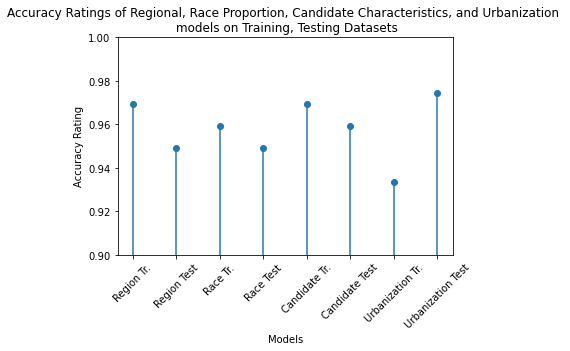

In [36]:
plt.stem(Accuracy)
plt.xticks(ticks = range(len(Types)), 
           labels = Types, rotation = 45)

plt.ylim([0.9, 1])
plt.ylabel("Accuracy Rating")
plt.xlabel("Models")
plt.title("Accuracy Ratings of Regional, Race Proportion, Candidate Characteristics, and Urbanization \n models on Training, Testing Datasets")



Note that the axis is from 0.9 to 1: the accuracy ratings are all closer than they appear. 

Results will not impress: accuracy values are likely slightly higher on average than the basic logit model, but not much, and many will likely have higher accuracy values in the training than testing case. This implies the extra variables are just causing the model to overfit to the variance in the training data. 

Most likely, there's just not much more accuracy to gain from adding more variables, as the variables already included in the basic logit function already have high predictive power. 

So, I'm going to just stick with the basic logit model from this point onwards.

# Part Four: Counterfactuals


A big motivator for the paper was seeing if there was a causal effect of candidate ideology (ie. if a Democratic candidate was very moderate and centrist, or very liberal, or in between) on election win probability. In my paper, I found large and significant coefficients on the `Blue_Dog` and `Justice_Democrat` variables (signifying if a candidate was a centrist or a liberal, respectively), and of comparable size to other results found in the literature. I will assume this change in win probability was causal.

So, now I want to play around with it, and see what differences we might expect in the US House of Representatives if more candidate had run as liberals or centrists. 

In [56]:
print("The number of Democrats who win in the real election was:", win.sum())

The number of Democrats who win in the real election was: 198


# Prediction: If all Democrats ran as Blue Dogs or Justice Democrats

First, I will take the full dataset for `X`, set all `blue_dog` variables to 1, and set all `justice_dem` variables to 0. This implies the whole Democratic Party running as centrists.

In order for `predict` to work, there have to be some rows with different values in each colum. I set row 390's Blue Dog value to 0, and row 391's Blue Dog value to 0 and Justice Democrat value to 1, so that we don't have perfect multicollearity. Both of these were in fairly Republican-leaning districts, so I wouldn't expect either to be winnable. 

In [38]:
X_BD = pd.DataFrame({"blue_dog": 1,
                  "justice_dem": 0,
                  "leaning": a_m_d_11["leaning"],
                  "median_income_std": a_m_d_11["median_income_std"],
                 "incumbent": a_m_d_11["Incumbent"]
})

X_BD.at[391, "blue_dog"] = 0
X_BD.at[390, "blue_dog"] = 0
X_BD.at[390, "justice_dem"] = 1

X_BD = sm.add_constant(X_BD)

In [39]:
X_BD.tail()

,const,blue_dog,justice_dem,leaning,median_income_std,incumbent
387,1.0,1,0,13,0.410261,0
388,1.0,1,0,8,-0.224496,0
389,1.0,1,0,8,-0.484215,0
390,1.0,0,1,7,-0.182897,0
391,1.0,0,0,25,-0.059912,0


logit_bd_predictions = logit_train.predict(X_BD)

In [40]:
logit_bd_predictions = logit_train.predict(X_BD)

In [41]:
pred_bd_wins = logit_bd_predictions.mean() * 392

In [42]:
dem_wins = win.mean()*392

Next, for the liberal case, I just do the inverse of the above, and set all candidates as Justice Democrats. The same candidates (index values 390 and 391) are changed again to make the prediction work.

In [43]:
X_JD = pd.DataFrame({"blue_dog": 0,
                  "justice_dem": 1,
                  "leaning": a_m_d_11["leaning"],
                  "median_income_std": a_m_d_11["median_income_std"],
                 "incumbent": a_m_d_11["Incumbent"]
})

X_JD.at[391, "blue_dog"] = 1
X_JD.at[390, "justice_dem"] = 0
X_JD.at[391, "justice_dem"] = 0

X_JD = sm.add_constant(X_JD)

In [44]:
X_JD.tail()

,const,blue_dog,justice_dem,leaning,median_income_std,incumbent
387,1.0,0,1,13,0.410261,0
388,1.0,0,1,8,-0.224496,0
389,1.0,0,1,8,-0.484215,0
390,1.0,0,0,7,-0.182897,0
391,1.0,1,0,25,-0.059912,0


In [45]:
logit_jd_predictions = logit_train.predict(X_JD)

In [46]:
pred_jd_wins = logit_jd_predictions.mean() * 392

In [47]:
print(f"The number of winning Democrats in the sample is: {round(dem_wins)}")
print(f"The number of predicted Democrat wins, if all ran as centrists, is {pred_bd_wins}")
print(f"The number of predicted Democrat wins, if all ran as liberals, is {pred_jd_wins}")

The number of winning Democrats in the sample is: 198
The number of predicted Democrat wins, if all ran as centrists, is 209.0
The number of predicted Democrat wins, if all ran as liberals, is 182.0


The real-life outcome of the election was the Democrats winning 235 of 435 seats. The sample was reduced to 392 because of 43 seats with abnormal elections - candidates running unopposed, against a weak independent or third party, or with many candidates running under a [Jungle Primary ruleset](https://en.wikipedia.org/wiki/Nonpartisan_blanket_primary). These were removed; most had lopsided results and would likely not change.


You can observe how many seats the Demcrats in the sample are expected to win. I'd expect that the centrist case increases their hold on the House, but doesn't reach a supermajority, while the liberal case weakens their hold but won't result in enough losses to lose them the chamber. Simply subtract 198 from the number of Centrist/Liberal case wins to see what the difference will be.

Due to the heavily nationalized media environment, candidates often struggle to distinguish themselves from their party. I would expect that the whole Democratic Party moving towards the center to have a much larger effect due to this. The predictions here essentially take the effect for a candidate on the margin, if he changed from a normal Democrat to a centrist, and apply it to everyone. The party changing how it's perceived by voters would cause an additional increase in electability.
